In [27]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import MockDevice as DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

임의의 QUBO 생성 (Constrain 있는 QUBO)

In [28]:
import numpy as np
import pandas as pd
import networkx as nx
diagonal = -20

def generate_distance_weighted_Q_matrix_with_soft_constraint(size=7, diagonal=-10, max_edges=4, penalty_term=5.0, hamming_weight=3, seed=42):
    """
    각 노드가 최대 max_edges 개의 엣지를 가지면서, 거리가 멀어질수록 가중치가 작아지는 Q 행렬을 생성.
    또한, 특정 개수만 선택되도록 하는 soft constraint를 추가.

    :param size: 생성할 행렬의 크기 (size x size)
    :param diagonal: 대각 원소 값
    :param max_edges: 각 노드가 가질 수 있는 최대 엣지 개수
    :param penalty_term: Hamming weight 제약을 위한 패널티 값
    :param hamming_weight: 선택해야 하는 노드 개수
    :param seed: 랜덤 시드 값 (재현 가능성 유지)
    :return: 거리 기반 가중치를 가지는 Q 행렬 (numpy array), 그래프, 노드 좌표
    """
    np.random.seed(seed)

    # 노드의 랜덤한 2D 좌표 생성
    coordinates = np.random.rand(size, 2) * 10  # 10x10 범위 내에서 랜덤 좌표

    # 노드 간 거리 계산
    distances = pdist(coordinates)  # 1D 배열 형태의 거리 정보
    distance_matrix = squareform(distances)  # 2D 대칭 행렬로 변환

    # 가중치는 거리의 역수의 제곱으로 설정 (거리가 멀어질수록 값이 작아짐)
    weights = 1 / (distance_matrix + np.eye(size))**2  # 자기 자신과의 거리는 제외
    # 그래프를 생성하여 각 노드의 연결을 제한
    G = nx.Graph()
    for i in range(size):
        G.add_node(i, pos=coordinates[i])  # 노드 좌표 저장

    # 가장 가까운 max_edges 개의 노드만 연결
    edges = []
    for i in range(size):
        closest_nodes = np.argsort(distance_matrix[i])  # 거리 기준으로 정렬
        connected = 0

        for j in closest_nodes:
            if i == j or connected >= max_edges or G.degree[j] >= max_edges:
                continue

            if (i, j) not in edges and (j, i) not in edges and weights[i, j] > 0:  # 0이 아닌 경우만 추가
                edges.append((i, j))
                G.add_edge(i, j, weight=weights[i, j])  # 가중치 추가
                connected += 1

    # Q 행렬 초기화
    Q = np.zeros((size, size))

    # 그래프의 엣지를 기반으로 Q 행렬 채우기
    for i, j in edges:
        Q[i, j] = weights[i, j]
        Q[j, i] = weights[j, i]  # 대칭성 유지

    # 대각 성분 설정
    np.fill_diagonal(Q, diagonal)

    # Soft Constraint 추가 (Hamming weight 제약)
    for i in range(size):
        Q[i, i] += penalty_term * (1 - 2 * hamming_weight)  # Hamming weight 페널티 적용
        for j in range(i + 1, size):
            Q[i, j] +=  penalty_term
            Q[j, i] +=  penalty_term  # 대칭성 유지

    return Q/10, G, coordinates

hamming_weight = 2

# 12x12 Q 행렬 생성 (Soft Constraint 포함)
Q, _, _ = generate_distance_weighted_Q_matrix_with_soft_constraint(
    size=6, diagonal=[-50,-1,-1,-1,-1], penalty_term=15.0, hamming_weight=hamming_weight
)




In [29]:
def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    Q_copy = np.array(Q)
    np.fill_diagonal(Q_copy, 0)
    print(np.linalg.norm((new_Q - Q_copy)**2))
    print(new_Q - Q_copy)
    return np.linalg.norm((new_Q - Q_copy))

def evaluate_mapping_Q(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    Q_copy = np.array(Q)
    np.fill_diagonal(new_Q, np.diag(Q))

    return new_Q

In [30]:
costs = []
np.random.seed(25)
# 초기 좌표를 정N각형의 형태로 배치
angles = np.linspace(0, 2 * np.pi, Q.shape[0], endpoint=False)
initial_positions = np.column_stack(( np.cos(angles),  np.sin(angles)))*6
initial_positions = np.reshape(initial_positions,-1)
res = minimize(
    evaluate_mapping,
    initial_positions,
    args=(Q,),
    method="COBYLA",
    tol=1e-6,
    options={"maxiter": 500, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))
Q_cord = evaluate_mapping_Q(coords, Q)

45549.93235283872
[[  0.         114.66883528   2.80269659   0.30587972   2.7936231
  114.66484958]
 [114.66883528   0.         114.67091298   2.80079444   0.28083674
    2.80114363]
 [  2.80269659 114.67091298   0.         114.67086228   2.80070813
    0.31373127]
 [  0.30587972   2.80079444 114.67086228   0.         114.66968183
    2.72050616]
 [  2.7936231    0.28083674   2.80070813 114.66968183   0.
  114.672808  ]
 [114.66484958   2.80114363   0.31373127   2.72050616 114.672808
    0.        ]]
38239.7081352126
[[  0.          66.66811942   1.14606694  -0.3863925    1.13699345
   66.66413372]
 [ 66.66811942   0.         114.67091298   2.80079444   0.28083674
    2.80114363]
 [  1.14606694 114.67091298   0.         114.67086228   2.80070813
    0.31373127]
 [ -0.3863925    2.80079444 114.67086228   0.         114.66968183
    2.72050616]
 [  1.13699345   0.28083674   2.80070813 114.66968183   0.
  114.672808  ]
 [ 66.66413372   2.80114363   0.31373127   2.72050616 114.672808
    0

c:\Users\pop75\anaconda3\envs\EMT\Lib\site-packages\scipy\optimize\_minimize.py:719: OptimizeWarning: Unknown solver options: maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


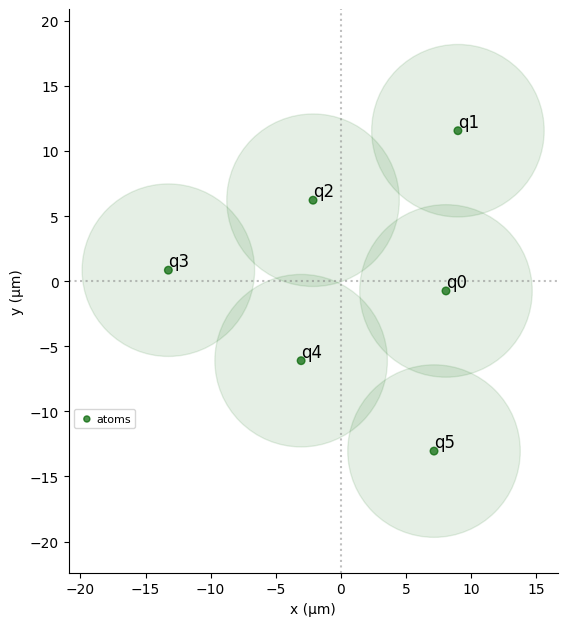

In [31]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

In [32]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q_cord @ z
    costs.append(cost)
zipped_cord = zip(bitstrings, costs)
sort_zipped_cord = sorted(zipped_cord, key=lambda x: x[1])
print(sort_zipped_cord[:6])

[('110101', -21.8010105512569), ('100101', -20.3644366229211), ('101101', -18.75350208501077), ('010101', -18.556293002052065), ('110001', -17.410056520323067), ('101001', -17.377456932862447)]


# Custom으로 만든 Simulator(Pulse_simulator)

입력 QUBO : Rydberg 원자의 QUBO

In [33]:
amplitude = [[0, 5, 0] for i in range(len(Q))]
detuning = [[Q[i][i],-Q[i][i]] for i in range(len(Q))]
duration = 2000

from pulse_simulatior import Pulse_simulation
pulse_sim = Pulse_simulation(Q_cord,amplitude,detuning,duration,step_time = 50) ## 펄스 시뮬레이션 객체 생성


final_state_expectations = pulse_sim.simulate_time_evolution()## 시뮬레이션 결과

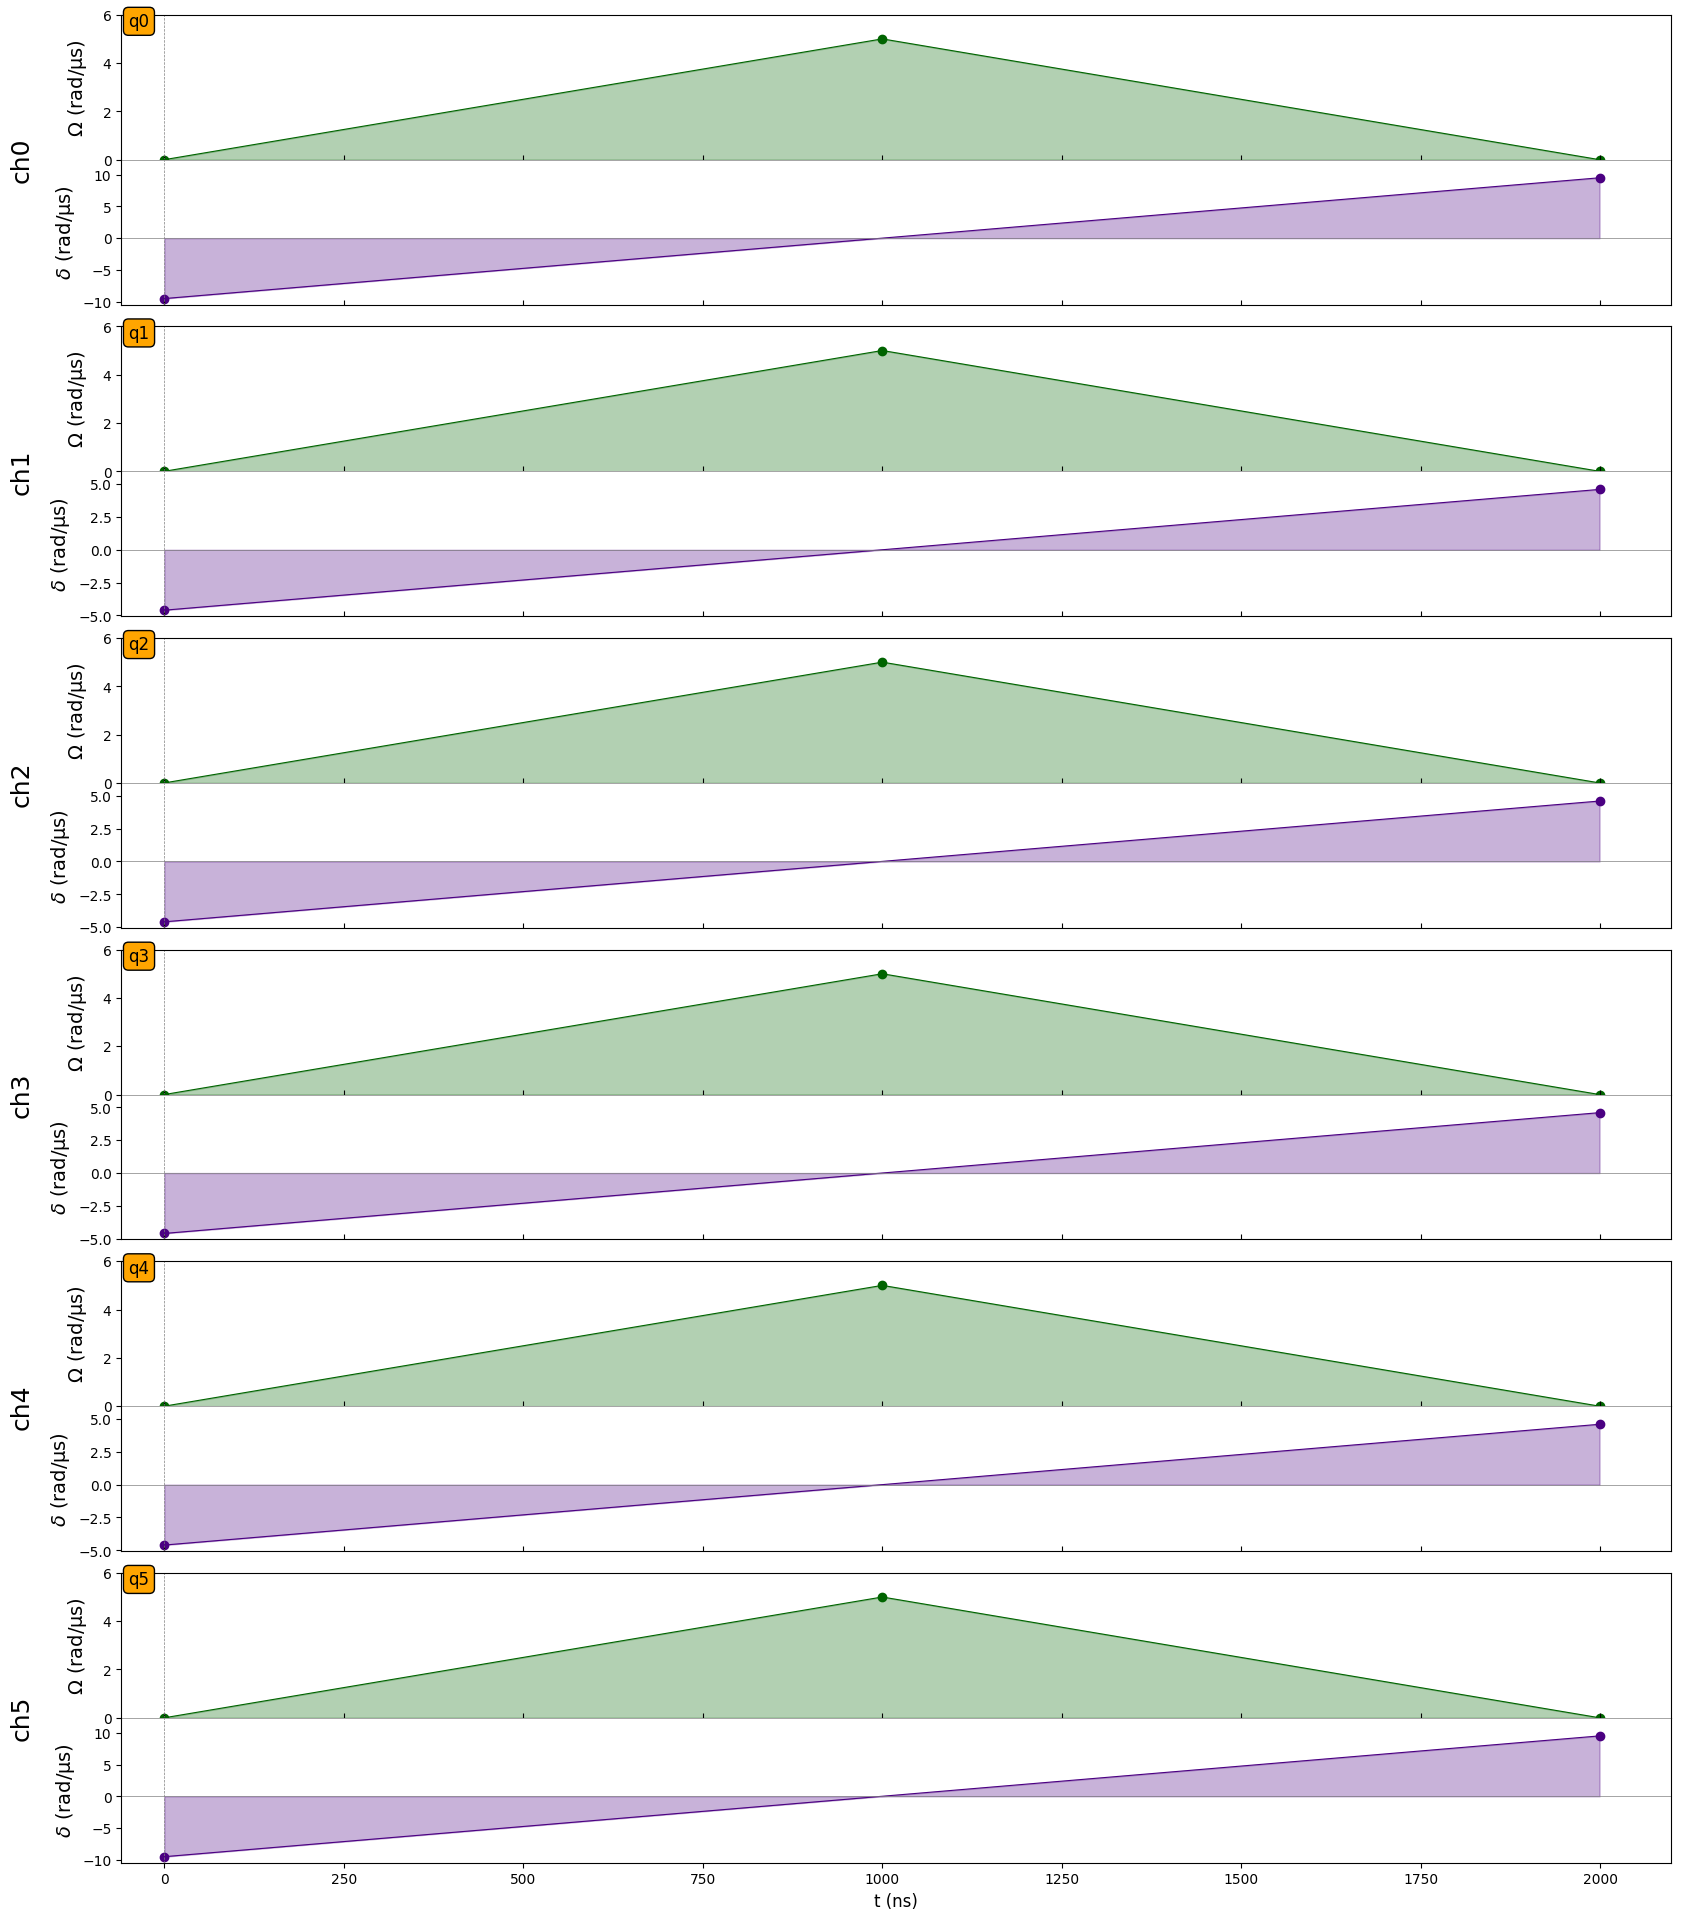

In [34]:
pulse_sim.draw() ## 펄스 모양 그리기

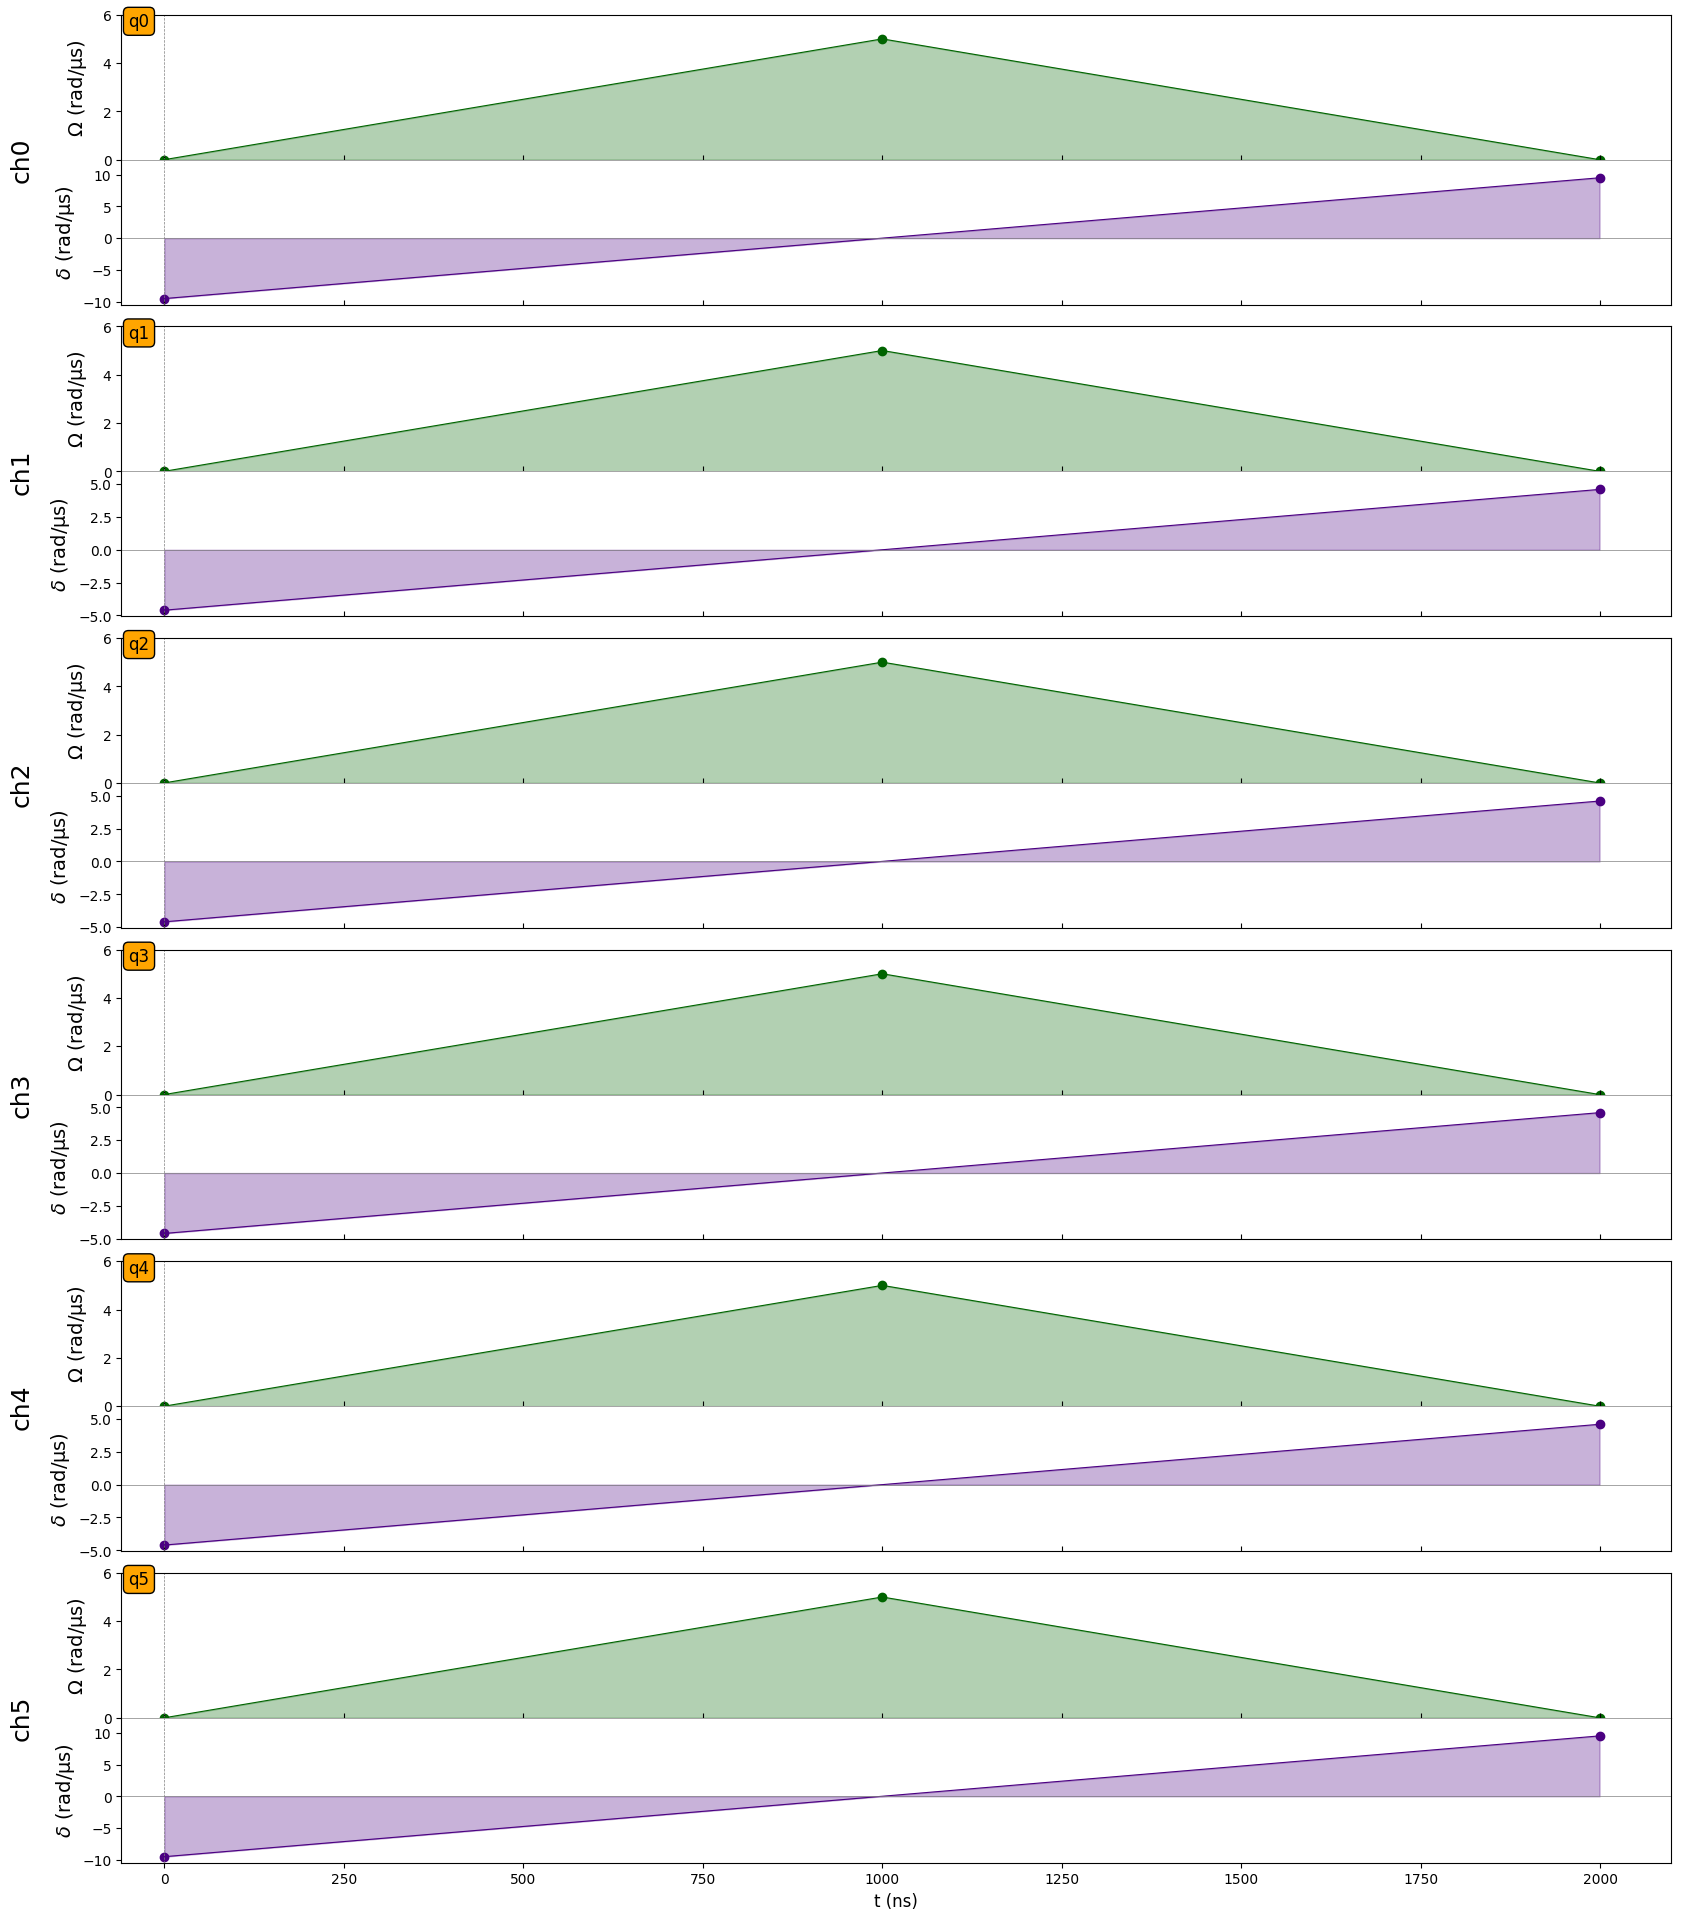

In [35]:
seq_temp = Sequence(reg, DigitalAnalogDevice) ## pulser 를 이용한 시퀀스 생성


for i in range(len(amplitude)):
    pulse = Pulse(
        InterpolatedWaveform(duration, amplitude[i],interpolator='interp1d'),
        InterpolatedWaveform(duration, detuning[i],interpolator='interp1d'),
        0,
    )
    seq_temp.declare_channel(f"ch{i}", "rydberg_local")
    seq_temp.target(f"q{i}", f"ch{i}")
    seq_temp.add(pulse, f"ch{i}") ## 위에 해당하는 그림과 동일한 펄스 pulser코드로 생성
    
seq_temp.draw() ## pulser 시퀀스 그리기


In [36]:
simul_1 = QutipEmulator.from_sequence(seq_temp)
results_1 = simul_1.run()
final_1 = results_1.get_final_state()
count_dict_1 = results_1.sample_final_state(1000000) ## pulser 코드를 이용한 시뮬레이션 결과 생성

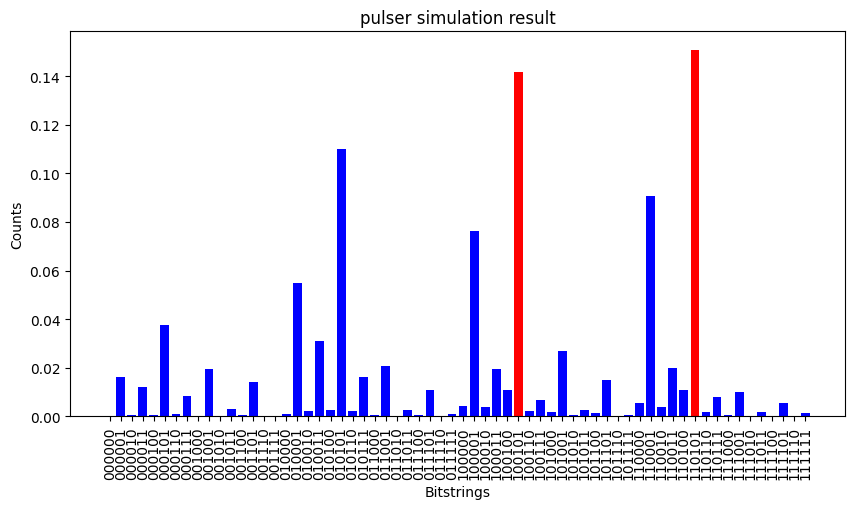

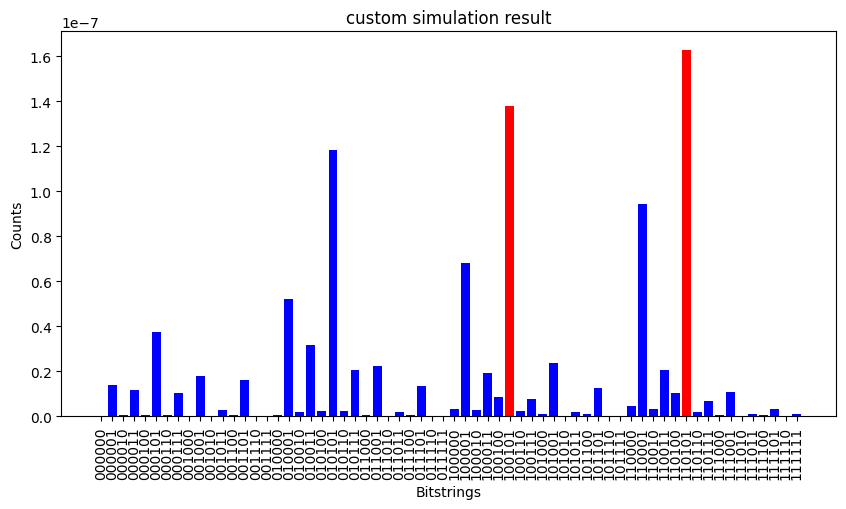

In [37]:
import matplotlib.pyplot as plt
from collections import Counter
def plot_bitstring_counts(input_data, bitstring_counts,label):
    """
    입력된 bitstring 목록을 기반으로 주어진 bitstring_counts에서 해당 bitstring을
    빨간색 막대로 강조하고, 나머지는 파란색으로 표시하는 그래프를 생성합니다.

    :param input_data: List of tuples (bitstring, value)
    :param bitstring_counts: Dictionary (bitstring -> count)
    """
    import matplotlib.pyplot as plt

    # 빨간색으로 강조할 bitstring 목록 추출
    highlighted_strings = {bitstring for bitstring, _ in input_data}

    # 데이터 준비
    bitstrings = list(bitstring_counts.keys())
    counts = np.array(list(bitstring_counts.values()))/1000000
    colors = ['red' if bitstring in highlighted_strings else 'blue' for bitstring in bitstrings]

    # 막대 그래프 그리기
    plt.figure(figsize=(10, 5))
    plt.bar(bitstrings, counts, color=colors)
    plt.xlabel("Bitstrings")
    plt.ylabel("Counts")
    plt.title(label)
    plt.xticks(rotation=90)
    plt.show()

def probs_to_dict(probs, num_qubits):
    """
    주어진 확률 배열을 bitstring 별로 매핑하여 딕셔너리 형태로 반환합니다.

    :param probs: 확률 배열
    :param num_qubits: 큐비트 개수
    :return: bitstring 별 확률을 담은 딕셔너리
    """
    bitstrings = [np.binary_repr(i, num_qubits) for i in range(2 ** num_qubits)]
    return {bitstring: probs[i] for i, bitstring in enumerate(bitstrings)}


plot_bitstring_counts(sort_zipped_cord[:2], count_dict_1,"pulser simulation result") 
plot_bitstring_counts(sort_zipped_cord[:2], probs_to_dict(final_state_expectations,len(Q)), "custom simulation result")